# Deep learning based quantum vortex detection in atomic Bose-Einstein condensates

Created by Friederike Metz

This jupyter notebook accompanies the paper: [Deep learning based quantum vortex detection in atomic Bose-Einstein condensates](https://arxiv.org/abs/2012.13097)

#### Content
1. Read and prepare training & test data
    * Add noise
3. Define architecture
    * Load pretrained model
4. Define loss function
5. Training
6. Model evaluation
    * Visualize the results

Import all necessary libraries

In [1]:
using Random, Distributions
using DelimitedFiles
using PyPlot
#using CuArrays # if gpu available
using Flux, NNlib
using Flux.Optimise: update!
using Base.Iterators: partition
using BSON: @save, @load

In [2]:
# costum functions needed for this notebook
include("utils.jl");

In [3]:
# fix random seed for reproducability
Random.seed!(1234);

## 1. Read and prepare training & test data

Read your training and/or test data here. As an example we will load two out-of-equilibria configurations and their ground-truth labels.

In [4]:
# image related parameters
n_images = 2
image_size = 256 # if this is changed the architecture of the NN has to be altered accordingly
max_objects = 50 # maximum number of vortices in any image (set it to a large value to be safe)

# grid related parameters
grid_size = 64 # if this is changed the architecture of the NN has to be altered accordingly
@assert image_size % grid_size == 0 # image_size should be divisible by grid_size
grid_cell = image_size ÷ grid_size;

In [5]:
# read images: the two channels are density and phase respectively
images = reshape(readdlm("example_data/images.dat"), image_size, image_size, 2, n_images)
# read corresponding ground truth postition obtained from "brute-force" detection
true_positions = reshape(readdlm("example_data/labels.dat"), max_objects, 2, n_images);

To help the CNN with training, image pixels should be normalized to lie between [0,1]

In [6]:
for i = 1:n_images
    scaling_factor = maximum(images[:,:,1,i])
    if scaling_factor != 1.0
        images[:,:,1,i] = images[:,:,1,i] ./ scaling_factor
        images[:,:,2,i] = (images[:,:,2,i] .+ pi) ./ (2*pi)
    end
end;

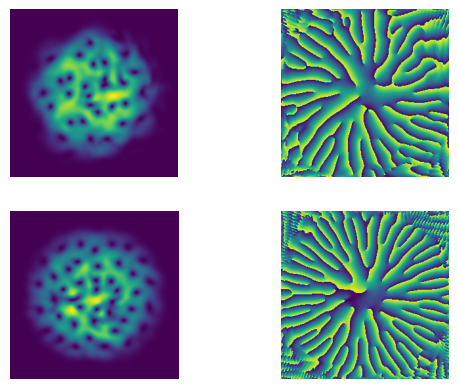

In [7]:
subplot(221)
PyPlot.imshow(images[:,:,1,1])
axis("off")
subplot(222)
PyPlot.imshow(images[:,:,2,1])
axis("off")
subplot(223)
PyPlot.imshow(images[:,:,1,2])
axis("off")
subplot(224)
PyPlot.imshow(images[:,:,2,2])
axis("off");

### Add noise
We can also add noise to the density snapshots to mimic experimental conditons.

In [8]:
# Gaussian random noise
# weak: sigma=0.1, moderate: sigma=0.2, strong: sigma=0.5
sigma = 0.1
d = Normal(0.0, sigma)
noisy_images = zeros(image_size, image_size, 2, n_images)
noisy_images[:,:,1,:] = images[:,:,1,:] .+ rand(d, (image_size, image_size, n_images))
noisy_images[:,:,2,:] = images[:,:,2,:];

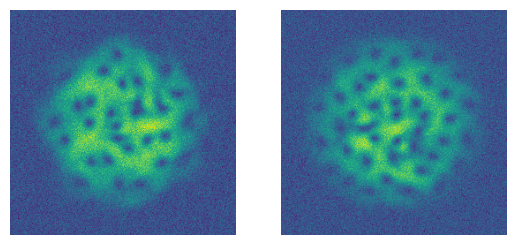

In [9]:
subplot(121)
PyPlot.imshow(noisy_images[:,:,1,1])
axis("off")
subplot(122)
PyPlot.imshow(noisy_images[:,:,1,2])
axis("off");

In [10]:
# Stripe noise
# weak: sigma=0.2, amplitude=0.2; moderate: sigma=0.5, amplitude=0.5; strong: sigma=1.0, amplitude=1.0
sigma = 0.2
amplitude = 0.2 
d = Normal(0.0, sigma) 
noisy_images = zeros(image_size, image_size, 2, n_images)
for i = 1:n_images
    a = 2.0 * rand() - 1.0
    b = (-1)^(bitrand(1)[1]) * (1 - abs(a))
    period = (15.0 - 7.0) * rand() + 7.0
    noisy_amplitude = amplitude .+ rand(d, (image_size, image_size))
    modulation = noisy_amplitude .* (cos.(2 .* pi .* (a .* collect(1:1:256) .+ b .* transpose(collect(1:1:256))) ./ period))./2
    noisy_images[:,:,1,i] = images[:,:,1,i] .+ modulation
end
noisy_images[:,:,2,:] = images[:,:,2,:];

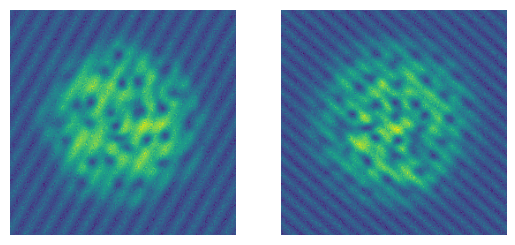

In [11]:
subplot(121)
PyPlot.imshow(noisy_images[:,:,1,1])
axis("off")
subplot(122)
PyPlot.imshow(noisy_images[:,:,1,2])
axis("off");

The following two cells convert the list of positions of vortices to a $64\times 63\times 3$ label tensor used for training and vice versa

In [12]:
# Convert list of x,y positions of each vortex to a 64x64x3 label tensor
true_labels = convert_positions_to_labels(true_positions);

In [13]:
# Convert 64x64x3 label tensor to list of x,y positions of each vortex
true_pos, confidence = convert_labels_to_positions(true_labels);

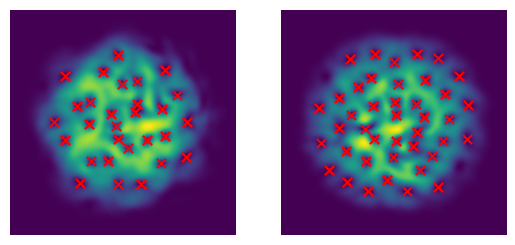

In [14]:
subplot(121)
PyPlot.imshow(images[:,:,1,1])
for i=1:size(true_pos[1], 1)
    PyPlot.scatter(true_pos[1][i,2]-1, true_pos[1][i,1]-1, s=45, marker="x", c="red")
end
axis("off");
subplot(122)
PyPlot.imshow(images[:,:,1,2])
for i=1:size(true_pos[2], 1)
    PyPlot.scatter(true_pos[2][i,2]-1, true_pos[2][i,1]-1, s=45, marker="x", c="red")
end
axis("off");

In [15]:
# Split data into training and test set
train_test_ratio = 0.5 #0.8
train_images, train_labels, test_images, test_labels = split_data(images, true_labels, train_test_ratio=train_test_ratio);

In [16]:
# Run this cell if you want to use density ONLY for training
train_images = train_images[:,:,1:1,:];

In [17]:
# Split training data into minitbatches (faster on cpu)
batch_size = 100

train_images = train_images|> cpu
train_labels = train_labels|> cpu

mb_idxs = partition(1:size(train_images, 4), batch_size)
train_set = [make_minibatch(train_images, train_labels, i) for i in mb_idxs];

In [18]:
# move data to gpu if available
train_images = train_images|> gpu
test_images = test_images|> gpu

train_labels = train_labels|> gpu
test_labels = test_labels|> gpu

train_set = train_set|> gpu;

## 2. Define architecture
The CNN architecture used for the paper. Input/output channels have to match the desired in and output of the CNN.

In [19]:
function initialize_model(input_channels; output_channels=3, channels=10, activation=relu)
    """ Returns randomly initialized CNN model """
    model = Chain(
        Conv((3, 3), input_channels=>channels, pad=(1,1), stride = 1, activation),
        Conv((3, 3), channels=>channels, pad=(1,1), stride = 1, activation),
        MaxPool((2,2), stride = 2),
        Conv((3, 3), channels=>2*channels, pad=(1,1), stride = 1, activation),
        Conv((3, 3), 2*channels=>2*channels, pad=(2,2), stride = 1, activation),
        MaxPool((2,2), stride = 2),
        Conv((3, 3), 2*channels=>3*channels, pad=(1,1), stride = 1, activation),
        MaxPool((2,2), stride = 1),
        Conv((3, 3), 3*channels=>4*channels, pad=(1,1), stride = 1, activation),
        Conv((1, 1), 4*channels=>output_channels, pad=(0,0), stride = 1, sigmoid),
    )|> gpu;
    return model
end;

In [20]:
# reset model
input_channels = size(train_images[:,:,:,1], 3)
model = initialize_model(input_channels);
# Check if the output dimensions are correct, i.e. match the label tensor
size(model(test_images[:,:,1:1,1:1]))

(64, 64, 3, 1)

### Load pretrained model

You can also use one of the models from the paper that has already been trained.

In [21]:
# one input channel (density only):
model_name = "density_wo_noise.bson"

#model_name = "density_weakgaussian_noise.bson"
#model_name = "density_moderategaussian_noise.bson"
#model_name = "density_stronggaussian_noise.bson"

#model_name = "density_weakstripe_noise.bson"
#model_name = "density_moderatestripe_noise.bson"
#model_name = "density_strongstripe_noise.bson"

# two input channels (density & phase):
#model_name = "density_and_phase_weakgaussian_noise.bson"
#model_name = "density_and_phase_moderategaussian_noise.bson"
#model_name = "density_and_phase_stronggaussian_noise.bson"

"density_wo_noise.bson"

In [22]:
# load weights
savepath="models/"
@load joinpath(savepath, model_name) weights
Flux.loadparams!(model, weights)

In [ ]:
# saving a model
#@save joinpath(savepath, "model_name.bson") weights=cpu.(Flux.params(model))

## 3. Define loss function

In [23]:
# Loss function for detection task
function loss(model, x, y) 
    """ Returns loss: Sum of cross-entropy loss for the class probability and L2 loss for the positions """
    y_hat = model(x)
    loss = sum((- 10.0f0 .* y[:,:,1,:] .* log.(y_hat[:,:,1,:] .+ 0.000001f0) .- (1 .- y[:,:,1,:]) .* log.(1 .- y_hat[:,:,1,:] .+ 0.000001f0))
            .+ 10.0f0 .* y[:,:,1,:] .* ((y_hat[:,:,2,:] .- y[:,:,2,:]).^2 .+ (y_hat[:,:,3,:] .- y[:,:,3,:]).^2)
            )
    return loss
end;

## 4. Training

In [ ]:
optimizer = ADAM(0.001)
epochs = 10

@time model, losses = train(loss,
                            optimizer,
                            epochs,
                            model,
                            train_set,
                            test_images[:,:,1:1,:], # adjust if phase is also used for training
                            test_labels);

In [ ]:
ylabel("Loss")
xlabel("Epoch")
plot(losses);

## 5. Model evaluation

To evaluate the performance of the vortex detector we compute average precision (AP) and the maximum F1 score. The corresponding optimal confindence threshold is then used to calculate the optimal precision and recall.

In [24]:
confidence_threshold = 0.75
distance_threshold = 2.3 # ~sqrt(5)

# Evaluation metrics
precisions, recalls, opt_conf_thres, f1_max = precision_recall_curve(model, test_images[:,:,1:1,:], test_labels; distance_threshold=distance_threshold)

# Compute precision & recall again at the optimal confidence threshold
precision, recall = mean_precision_and_recall(model, test_images[:,:,1:1,:], test_labels; confidence_threshold=opt_conf_thres, distance_threshold=distance_threshold)

println("Optimal confidence threshold: ", opt_conf_thres)
println("Optimal precision: ", precision)
println("Optimal recall: ", recall)
println("AP: ", mean(precisions))
println("Max F1 score: ", f1_max)

Optimal confidence threshold: 0.55
Optimal precision: 1.0
Optimal recall: 1.0
AP: 0.9679368279569893
Max F1 score: 1.0


In [ ]:
plot(recalls, precisions)
xlabel("Recall")
ylabel("Precision");

### Visualize the results
Compare the predicted and ground-truth positions

In [25]:
opt_conf_thres=0.75

predicted_labels = nms(model(images[:,:,1:1,1:2]|> gpu)) # nms: non-max suppression
predicted_pos, conf = convert_labels_to_positions(predicted_labels, threshold=opt_conf_thres)
true_pos, conf = convert_labels_to_positions(true_labels);

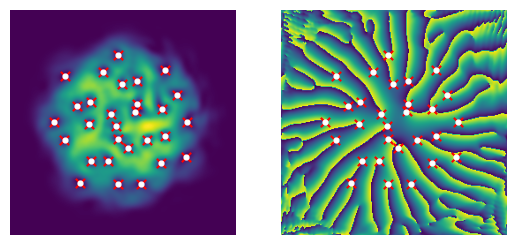

In [26]:
n = 1 # change to see the other images
subplot(121)
PyPlot.imshow(images[:,:,1,n])
for i=1:size(predicted_pos[n], 1)
    PyPlot.scatter(predicted_pos[n][i,2]-1, predicted_pos[n][i,1]-1, s=45, marker="x", c="red")
end
for i=1:size(true_pos[n], 1)
    PyPlot.scatter(true_pos[n][i,2]-1, true_pos[n][i,1]-1, s=12, marker="o", c="white")
end
axis("off")
subplot(122)
PyPlot.imshow(images[:,:,2,n])
for i=1:size(predicted_pos[n], 1)
    PyPlot.scatter(predicted_pos[n][i,2]-1, predicted_pos[n][i,1]-1, s=45, marker="x", c="red")
end
for i=1:size(true_pos[n], 1)
    PyPlot.scatter(true_pos[n][i,2]-1, true_pos[n][i,1]-1, s=12, marker="o", c="white")
end
axis("off");

In the figures above white circles indicate the "ground-truth" and red crosses the model prediction